<small><i>This notebook was put together by [Abel Meneses-Abad](http://www.menesesabad.com) for Paper *Paraphrase Beyond Sentence*. Source and license info is on [GitHub](https://github.com/sorice/2017paraphrasebsent/).</i></small>

# Preprocessing Data

In [1]:
%matplotlib inline
# use seaborn plotting style defaults
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## From CSV to Sklearn Bunch

In [24]:
import csv
import numpy as np
from sklearn.datasets.base import Bunch

with open('data/MSRPC-2004/msrpc_test_textsim-42fb.csv') as csv_file:
    data_file = csv.reader(csv_file)
    temp = next(data_file)
    n_samples = int(temp[0])
    n_features = int(temp[1])
    target_names = np.array(temp[2:4])
    feature_names = np.array(temp[4:-1])
    data = np.empty((n_samples, n_features))
    target = np.empty((n_samples,), dtype=np.int)
    
    for i, ir in enumerate(data_file):
        data[i] = np.asarray(ir[:-1], dtype=np.float)
        if 'yes' in ir[-1]:
            ir[-1] = 1
        elif 'no' in ir[-1]:
            ir[-1] = 0
        target[i] = np.asarray(ir[-1], dtype=np.int)

    fdescr = ''
        
msrpc = Bunch(data=data, target=target,
    target_names=target_names,
    DESCR=fdescr,
    feature_names=feature_names)

x = msrpc['data']
Y = msrpc['target']

input_dataset = np.column_stack([x,Y]) #Auxiliar dataset array for printing

In [27]:
data.shape

(1671, 43)

In [16]:
feature_names,len(feature_names)

(array(['binary_distance', 'braycurtis_distance', 'canberra_distance',
        'chebyshev_distance', 'containment_distance',
        'correlation_distance', 'cosine_distance',
        'damerau_levenshtein_distance', 'dice_coefficient', 'dice_distance',
        'edit_similarity', 'euclidean_distance', 'hamming_distance',
        'interval_distance', 'jaccard_distance', 'jaro_distance',
        'jaro_winkler_distance', 'kulsinski_distance', 'lcs_distance',
        'lcs_similarity', 'levenshtein_distance', 'mahalanobis_distance',
        'manhattan_distance', 'masi_distance', 'match_rating_comparison',
        'matching_coefficient', 'matching_coefficient_pablo',
        'matching_distance', 'minkowski_distance',
        'needleman_wunsch_distance', 'needleman_wunsch_similarity',
        'overlap_distance', 'rogerstanimoto_distance',
        'russellrao_distance', 'seuclidean_distance',
        'smith_waterman_distance', 'sokalmichener_distance',
        'sokalsneath_distance', 'sqeuclide

In [17]:
print(x.mean(),Y[:20])

nan [1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1]


**Note:** The mean value can be obtained due to *'NaN'* values inside data.

## Imputing missing values

Read the page 102 of the book "Python Machine Learning Unlock deeper insights ..." (Raschka2015).

In [26]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(x)
x2 = imr.transform(x)
print(x2.shape)
x2.mean()

(1671, 42)


35.89751224859706

**Note:** In the 04.3-Classification-vs-Outliers notebook after some experiments was discovered a shape change in the data matrix because of the *Imputer* method. This change of shape isn't commented in any readed book until now. Imputer method is used here because it is the classic example, but a better way to deal with 'Nan' and without a shape change can be found in the notebook 04.3.

## Feature Scaling

Transforming all features to the same scale.

In [7]:
import scipy
from sklearn.preprocessing import scale

# A varian & Recomended: scale the data such that mean = 0 and standard deviation = 1
# see "Python Machine Learning Unlock deeper insights ..." (Raschka2015), pag 111, first paragrah.
x_s = scale(x2,with_mean=True,with_std=True,axis=0)

# B variant: Second way to scale
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_s2 = mms.fit_transform(x)

# C variant & Recomended: Same as way A
# see "Python Machine Learning Unlock deeper insights ..." (Raschka2015), pag 111, first paragrah.
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
x_s3 = stdsc.fit_transform(x)

print(np.max(x_s2), np.max(x_s3), np.max(x_s2 - x_s3))

1.0 18.7497487961 20.9387536316


## Partitioning a dataset in training and test sets



In [8]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_s, Y, test_size=0.3, random_state=4)
train,test=train_test_split(input_dataset,test_size=0.3)

### Stratified Split

In order to achieve equal class distribution in	the	training and the test sets.

Code from "Python Data Science Cookbook", page 538, Subramanian2015.

In [9]:
from sklearn.cross_validation import StratifiedShuffleSplit

def get_train_test(x,y):
    """
    Perpare a stratified train and test split
    """
    train_size = 0.7
    test_size = 1-train_size
    input_dataset = np.column_stack([x,y])
    stratified_split = StratifiedShuffleSplit(input_dataset[:,-1],test_size=test_size,n_iter=1)
    for train_indx,test_indx in stratified_split:
        train_x = input_dataset[train_indx,:-1]
        train_y = input_dataset[train_indx,-1]
        test_x = input_dataset[test_indx,:-1]
        test_y = input_dataset[test_indx,-1]
    return train_x,train_y,test_x,test_y

Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_s,Y)

In [10]:
def get_class_distribution(y):
    """Given an array of class labels
    Return the class distribution
    """
    distribution = {}
    set_y = set(y)
    for y_label in set_y:
        no_elements = len(np.where(y == y_label)[0])
        distribution[y_label] = no_elements
    dist_percentage = {class_label: count/(1.0*sum(distribution.values())) 
                       for class_label,count in distribution.items()}
    return dist_percentage

In [11]:
def print_class_label_split(train,test):
    """
    Print the class distribution
    in test and train dataset
    """
    y_train = train[:,-1]
    
    train_distribution = get_class_distribution(y_train)
    print("\nTrain dat set class label distribution")
    print("=========================================\n")
    for k,v in train_distribution.items():
        print("Class label =%d, percentage records =%.2f"%(k,v))
    
    y_test = test[:,-1]
    
    test_distribution = get_class_distribution(y_test)
    
    print("\nTest data set class label distribution")
    print("=========================================\n")
    
    for k,v in test_distribution.items():
        print("Class label =%d, percentage records =%.2f"%(k,v))

In [12]:
print_class_label_split(train,test)


Train dat set class label distribution

Class label =0, percentage records =0.35
Class label =1, percentage records =0.65

Test data set class label distribution

Class label =0, percentage records =0.31
Class label =1, percentage records =0.69


In [13]:
Xs_test.shape,Xs_train.shape, X_test.shape, X_train.shape

((502, 42), (1169, 42), (502, 42), (1169, 42))

### Stratified KFold

In [14]:
from sklearn.cross_validation import KFold,StratifiedKFold

In [15]:
def class_distribution(y):
    class_dist = {}
    total = 0
    for entry in y:
        try:
            class_dist[entry]+=1
        except KeyError:
            class_dist[entry]=1
        total+=1
    
    for k,v in class_dist.items():
        print ("\tclass %d percentage =%0.2f"%(k,v/(1.0*total)))

In [16]:
#3 folds
kfolds = KFold(n=Y.shape[0],n_folds=3)
fold_count = 1
for train,test in kfolds:
    print("Fold %d x train shape"%(fold_count),x_s[train].shape,\
    " x test shape",x_s[test].shape)
    fold_count==1

#Stratified KFold
skfolds = StratifiedKFold(Y,n_folds=3)
fold_count = 1
yk_train = {}
for train,test in skfolds:
    print("\nFold %d x train shape"%(fold_count),x_s[train].shape,\
    " x test shape",x_s[test].shape)
    yk_train[fold_count] = Y[train]
    xk_train = x_s[train]
    yk_test = Y[test]
    xk_test = x_s[test]
    print ("Train Class Distribution")
    class_distribution(yk_train)
    print ("Test Class Distribution")
    class_distribution(yk_test)
    fold_count+=1



Fold 1 x train shape (1114, 42)  x test shape (557, 42)
Fold 1 x train shape (1114, 42)  x test shape (557, 42)
Fold 1 x train shape (1114, 42)  x test shape (557, 42)

Fold 1 x train shape (1113, 42)  x test shape (558, 42)
Train Class Distribution
	class 1 percentage =1.00
Test Class Distribution
	class 0 percentage =0.34
	class 1 percentage =0.66

Fold 2 x train shape (1114, 42)  x test shape (557, 42)
Train Class Distribution
	class 1 percentage =0.50
	class 2 percentage =0.50
Test Class Distribution
	class 0 percentage =0.34
	class 1 percentage =0.66

Fold 3 x train shape (1115, 42)  x test shape (556, 42)
Train Class Distribution
	class 1 percentage =0.33
	class 2 percentage =0.33
	class 3 percentage =0.33
Test Class Distribution
	class 0 percentage =0.34
	class 1 percentage =0.66


In [17]:
type(xk_test)
yk_train[1].shape

(1113,)

## Detection and Tratement of Outliers

See Boschetti & Massaron 2015, "Python Data Science Essentials", page 102.

In [18]:
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

pca = PCA(n_components=2)
x_z = pca.fit_transform(x_s)
vtot = 'PCA Variance explained ' + str(round(np.sum(pca.explained_variance_ratio_),3))
v1 = str(round(pca.explained_variance_ratio_[0],3))
v2 = str(round(pca.explained_variance_ratio_[1],3))
robust_covariance_est = EllipticEnvelope(store_precision=False, 
                                         assume_centered = False, contamination=.05)
robust_covariance_est.fit(x_z)
detection = robust_covariance_est.predict(x_z)
outliers = np.where(detection==-1)
regular = np.where(detection==1)

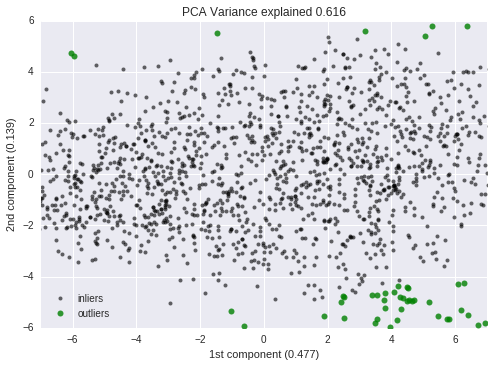

In [19]:
# Draw the distribution and the detected outliers
from matplotlib import pyplot as plt
a = plt.plot(x_z[regular,0],x_z[regular,1],
'o', markersize=4, color='black', alpha=0.6, label='inliers')
b = plt.plot(x_z[outliers,0],x_z[outliers,1],
'o', markersize=6,color='green', alpha=0.8, label='outliers')
plt.xlabel('1st component ('+v1+')')
plt.ylabel('2nd component ('+v2+')')
plt.xlim([-7,7])
plt.ylim([-6,6])
plt.legend((a[0],b[0]),('inliers','outliers'),numpoints=1,loc='best')
plt.title(vtot)
plt.show()

In [20]:
len(outliers[0])

84

## Feature Selection

Read the page 118 of the book "Python Machine Learning Unlock deeper insights ..." (Raschka2015).

In [21]:
from sklearn import feature_selection
from sklearn.feature_selection import chi2

In [22]:
#Note: SelectKBest doesn't work with none positive values, we use x_s2 for that reason.
x_n = feature_selection.SelectKBest(chi2, k=10).fit_transform(x_s2, Y)

In [23]:
x_n.shape

(1671, 10)

In [30]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [31]:
class SBS():
    def __init__(self, estimator, k_features,
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size,
                                    random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                    X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                            X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train,
                            X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [97]:
#from sklearn.neighbors import KNeighborsClassifier
#import matplotlib.pyplot as plt
#knn = KNeighborsClassifier(n_neighbors=3)
#from sklearn.ensemble import RandomForestClassifier
#forest = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()
clf = SVC(kernel='linear')
#forest.fit(Xs_train, ys_train)
sbs = SBS(clf, k_features=1)
sbs.fit(Xs_train, ys_train)

In [99]:
sbs.scores_.index(max(sbs.scores_))

11

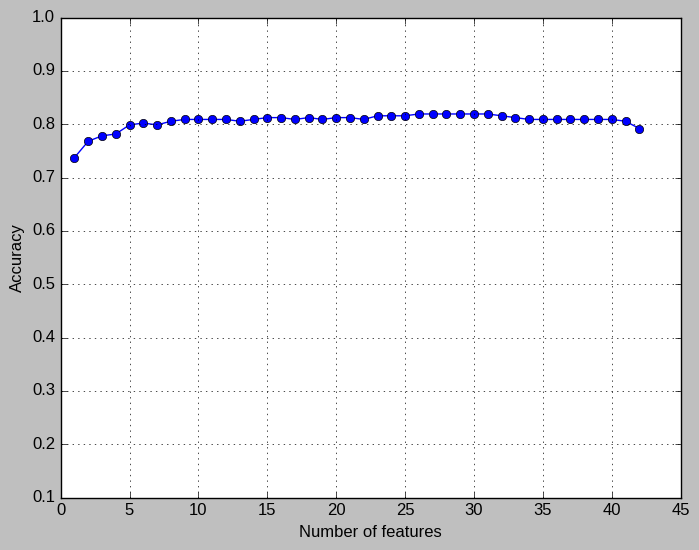

In [100]:
sns.reset_orig()
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.1, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [101]:
k5 = list(sbs.subsets_[11])
print(feature_names[k5])

['euclidean_distance' ' damerau_levenshtein_distance'
 ' levenshtein_distance' ' masi_distance' ' dice_coefficient'
 ' jaro_distance' ' braycurtis_distance' ' rogerstanimoto_distance'
 ' kulsinski_distance' ' matching_coefficient_pablo'
 ' match_rating_comparison' ' token_containment_distance'
 ' sokalmichener_distance' ' smith_waterman_distance'
 ' matching_coefficient' ' minkowski_distance' ' jaro_winkler_distance'
 ' correlation_distance' ' matching_distance' ' manhattan_distance'
 ' russellrao_distance' ' lcs_distance' ' sokalsneath_distance'
 ' needleman_wunsch_similarity' ' canberra_distance' ' dice_distance'
 ' containment_distance' ' interval_distance' ' jaccard_distance'
 ' lcs_similarity' ' edit_similarity']


In [75]:
k5 = list(sbs.subsets_[18])
print(feature_names[k5])

['euclidean_distance' ' damerau_levenshtein_distance'
 ' levenshtein_distance' ' dice_coefficient' ' jaro_distance'
 ' braycurtis_distance' ' matching_coefficient_pablo'
 ' match_rating_comparison' ' token_containment_distance'
 ' smith_waterman_distance' ' matching_coefficient' ' minkowski_distance'
 ' mahalanobis_distance' ' correlation_distance' ' matching_distance'
 ' manhattan_distance' ' lcs_distance' ' needleman_wunsch_similarity'
 ' canberra_distance' ' dice_distance' ' containment_distance'
 ' lcs_similarity' ' edit_similarity' ' hamming_distance']


## Model Evaluation Example

In [107]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, x_s, Y, cv=10, scoring='accuracy').mean()

0.74684559452523525

In [88]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30)
cross_val_score(knn, x_s, Y, cv=10, scoring='accuracy').mean()

0.72767623101473478

In [90]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
cross_val_score(forest, x_s, Y, cv=10, scoring='accuracy').mean()

0.72584413788601787

In [110]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
cross_val_score(clf, x_s, Y, cv=10, scoring='accuracy').mean()

0.75165396401688866

The two best models are SVC and LogisticRegression. Let will see the results of this two models using **x_n** data (the 10 best features selected using SelectKBest)

In [106]:
cross_val_score(logreg, x_n, Y, cv=10, scoring='accuracy').mean()

0.73664783170320292

In [111]:
cross_val_score(clf, x_n, Y, cv=10, scoring='accuracy').mean()

0.74203366073361032

## Feature Importance

Code from page 124 of the book "Python Machine Learning Unlock deeper insights ..." (Raschka2015).

**Note**: This kind of evaluation of features, just assigned a rank to distances, but no group them or rerank it to get the most N important features.

In [27]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(Xs_train, ys_train)
importances = forest.feature_importances_

In [28]:
indices = np.argsort(importances)[::-1]
for f in range(Xs_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[f], importances[indices[f]]))

 1) euclidean_distance             0.051584
 2)  damerau_levenshtein_distance  0.045922
 3)  levenshtein_distance          0.044593
 4)  masi_distance                 0.044066
 5)  dice_coefficient              0.043551
 6)  jaro_distance                 0.037226
 7)  braycurtis_distance           0.035751
 8)  cosine_distance               0.033823
 9)  rogerstanimoto_distance       0.032912
10)  kulsinski_distance            0.032423
11)  matching_coefficient_pablo    0.032387
12)  match_rating_comparison       0.031479
13)  overlap_distance              0.031235
14)  token_containment_distance    0.026167
15)  sokalmichener_distance        0.025467
16)  smith_waterman_distance       0.025291
17)  matching_coefficient          0.025013
18)  minkowski_distance            0.025003
19)  jaro_winkler_distance         0.022806
20)  mahalanobis_distance          0.022678
21)  correlation_distance          0.022573
22)  matching_distance             0.022151
23)  manhattan_distance         

# Conclusions

The data preparation is a very important step in Machine Learning process. Its understanding implied full knowledge of file operations, data behaviour, math implications of missing or non-scaled values, the validation process implications with train and test data, outliers significance and feature selection importance to improve the accuracy of our models.

Section *model evaluation example* shows that with only 10 features is possible to get results over 0.74 in accuracy metric.

# Recomendations

* Read about **unregularized models** where *dimensionality reduction* via feature selection, is an alternative way to reduce the complexity of the model and avoid overfitting.

* Study the way to introduce Stritified Kfold data in real experiments to fix the seeds and make comparable the results between different classifiers.

* The eliminations of outliers or their substitution by the mean is not trated here. The relevance of their elimination depends on the classifier selected, some models are not sensitive to outliers.

* Besides neither is trated an easy way to remove outliers from a multivariate data.

# Questions

* Test feature selection in sparse data with linear models like Lasso or Logistic Regresion.
* Use the class SelectFromModel inside feature_selection module, and try different classification models like svm, knn, etc.
* Make a secuence of feature selection with SVM and a set of kernels like RBF ('rbf'), Gram Matrix ('precomputed'), Cosine('cosine'), 'linear', Polinomial('poly'), Sigmoid and a self kernel. Compare the selected features and their rank. 

# References and Resources

* Sebastian Raschka, Book "Python Machine Learning". Packt Publishing, 2015.
<a id='Raschka2015'></a>

* Gopi Subramanian, Book "Python Data Science Cookbook". Packt Publishing, 2015.
<a id='Subramanian2015'></a>

* Alberto Boschetti & Luca Massaron, Book "Python Data Science Essential". Packt Publishing, 2015.
<a id='Boschetti2015'></a>

* Trent Hauck, Book "Scikit-learn Cookbook". Packt Publishing, 2014.
<a id='Hauck2015'></a>